# Лабораторная работа №3 по курсу "Методы, средства и технологии мультимедиа"

Студент - Шавандрин Фёдор Михайлович  
Группа - М8О-408Б-19

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
mobile_filepath = "./train.csv"

In [3]:
mobile_data = pd.read_csv(mobile_filepath)

In [4]:
mobile_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


### Подготовка данных

In [5]:
target = 'price_range'
categorical_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
numerical_features = [feature for feature in list(mobile_data.columns) if feature != target and feature not in categorical_features]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

In [7]:
data_preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), categorical_features),
    ('minmax', MinMaxScaler(), [feature for feature in numerical_features])
])

In [8]:
mobile_data.loc[mobile_data.price_range == 1, 'price_range'] = 0
mobile_data.loc[mobile_data.price_range == 2, 'price_range'] = 1
mobile_data.loc[mobile_data.price_range == 3, 'price_range'] = 1

In [9]:
mobile_data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,1
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,1
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,0


### Дата-сплиттинг

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = mobile_data.drop(target, axis=1)
y = mobile_data[target]
assert len(X) == len(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=66)

In [13]:
X_train.shape, X_test.shape

((1400, 20), (600, 20))

## Часть 1. Реализация логистической регрессии.

Реализовал логистическую регрессию численным методом с использованием градиентного спуска.

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV

In [15]:
class My_log_regression(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=10, lr=0.1, batch_size=256):
        self.w = None
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n, k = X.shape
        
        if self.w is None:
            np.random.seed(0xDEAD)
            self.w = np.random.randn(k + 1)

        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        for i in range(self.epochs):
            for j in range(0, len(X), self.batch_size):
                X_batch = X[j:j+self.batch_size]
                y_batch = y[j:j+self.batch_size]
                
                y_pred = self._predict_proba_internal(X_batch)
                self.w -= self.lr * self._get_gradient(X_batch, y_batch, y_pred)

        return self
    
    def _get_gradient(self, X_batch, y_batch, y_pred):
        gradient = X_batch.T @ (y_pred - y_batch)
        return gradient
        
    def predict_proba(self, X):
        X = check_array(X)
        
        n = X.shape[0]
        X = np.concatenate((np.ones((n, 1)), X), axis=1)
        return self._sigmoid(np.dot(X, self.w))

    def _predict_proba_internal(self, X):
        return self._sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) > threshold
    
    def _sigmoid(self, a):
        return 1. / (1 + np.exp(-a))

In [16]:
my_logreg_pipe = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('logreg', My_log_regression())
    ]
)

### Метрики. Сравнение с моделью из sklearn.

В качестве основных выберу следующие метрики:

    1. Accuracy
    2. Recall
    3. Precision
    4. ROC AUC
    5. Confusion matrix

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

In [18]:
def get_metrics(model, X, y_true, threshold=0.5, use_probas=True):
    
    if use_probas:
        y_pred_probas = model.predict_proba(X)
        if len(y_pred_probas.shape) == 2:
            y_pred_probas = y_pred_probas[:, 1] 
        y_pred = y_pred_probas > threshold
    else:
        y_pred = model.predict(X)
    
    print('Accuracy = ', accuracy_score(y_true, y_pred))
    print('Precision = ', precision_score(y_true, y_pred))
    print('Recall = ', recall_score(y_true, y_pred))
    if use_probas:
        print('ROC AUC = ', roc_auc_score(y_true, y_pred_probas))
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))

**Моя логистическая регрессия**

In [19]:
my_logreg_grid_search = GridSearchCV(my_logreg_pipe, 
{'logreg__lr': [0.0001, 0.001, 0.01, 0.025, 0.05, 0.5, 0.2, 0.25, 0.15, 0.005],
'logreg__epochs': [25, 50, 75, 100, 125, 150, 175, 200]})
my_logreg_grid_search.fit(X_train, y_train);

In [20]:
my_logreg_grid_search.best_params_

{'logreg__epochs': 150, 'logreg__lr': 0.25}

In [21]:
get_metrics(my_logreg_grid_search, X_test, y_test, threshold=0.129)

Accuracy =  0.985
Precision =  0.9741935483870968
Recall =  0.9966996699669967
ROC AUC =  0.9992777055483326
Confusion matrix:
[[289   8]
 [  1 302]]


### Модель из sklearn

In [22]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(
    steps=[
        ('preprocessing', data_preprocessing),
        ('logreg', LogisticRegression(class_weight='balanced', solver='saga', max_iter=3000))
    ]
)

param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 0.25, 0.5, 1],
}

In [23]:
logreg_grid_search = GridSearchCV(logreg_pipe, param_grid)

In [24]:
logreg_grid_search.fit(X_train, y_train);

In [25]:
logreg_grid_search.best_params_

{'logreg__C': 1, 'logreg__penalty': 'l1'}

In [26]:
get_metrics(logreg_grid_search, X_test, y_test, threshold=0.588)

Accuracy =  0.9833333333333333
Precision =  0.9966101694915255
Recall =  0.9702970297029703
ROC AUC =  0.9995221744396663
Confusion matrix:
[[296   1]
 [  9 294]]


Как можно заметить, моя модель логистической регрессии имеет незначительное преимущество в accuracy (~0.002%), чем модель из sklearn.

## Часть 2 Линейная регрессия

In [27]:
bottle = pd.read_csv("./bottle.csv", low_memory=False)
bottle.head()

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
bottle.describe()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,BtlNum,...,R_CHLA,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1
count,864863.000000,864863.000000,864863.000000,853900.000000,817509.000000,696201.000000,812174.000000,661274.000000,661268.000000,118667.000000,...,225276.000000,225275.000000,864863.000000,122006.000000,1999.000000,224.000000,2084.000000,234.000000,10.000000,84.000000
mean,17138.790958,432432.000000,226.831951,10.799677,33.840350,3.392468,25.819394,57.103779,148.808694,10.497426,...,0.450225,0.198599,228.395694,162.071521,2153.239714,2168.148330,2256.055845,2278.858803,7.948570,7.910983
std,10240.949817,249664.587269,316.050259,4.243825,0.461843,2.073256,1.167787,37.094137,90.187533,6.189688,...,1.208566,0.376539,319.456731,85.722796,112.995202,154.852332,34.844435,58.496495,0.021216,0.077666
min,1.000000,1.000000,0.000000,1.440000,28.431000,-0.010000,20.934000,-0.100000,-0.434900,0.000000,...,-0.010000,-3.890000,0.000000,0.000000,1948.850000,1969.440000,2181.570000,2198.150000,7.923100,7.618300
25%,8269.000000,216216.500000,46.000000,7.680000,33.488000,1.360000,24.965000,21.100000,60.915470,5.000000,...,0.050000,0.050000,46.000000,200.000000,2028.330000,2008.977500,2230.322500,2229.062500,7.931475,7.898675
50%,16848.000000,432432.000000,125.000000,10.060000,33.863000,3.440000,25.996000,54.400000,151.064150,10.000000,...,0.160000,0.110000,126.000000,206.000000,2170.640000,2265.885000,2244.325000,2247.505000,7.946650,7.928850
75%,26557.000000,648647.500000,300.000000,13.880000,34.196900,5.500000,26.646000,97.600000,240.379600,16.000000,...,0.390000,0.230000,302.000000,214.000000,2253.810000,2315.525000,2278.505000,2316.452500,7.963300,7.955100
max,34404.000000,864863.000000,5351.000000,31.140000,37.034000,11.130000,250.784000,214.100000,485.701800,25.000000,...,66.110000,65.300000,5458.000000,424.000000,2367.800000,2364.420000,2434.900000,2437.000000,7.988300,8.047700


In [29]:
# Выделяем данные температуры и солёности для построения графиков
bottle_df = bottle[['T_degC','Salnty']]
bottle_df.columns = ['Temperature', 'Salinity']

In [30]:
bottle_df = bottle_df[:][:500]      # lets take limit for speed regression calculating
bottle_df.head()

,Temperature,Salinity
0,10.50,33.440
1,10.46,33.440
2,10.46,33.437
3,10.45,33.420
4,10.45,33.421


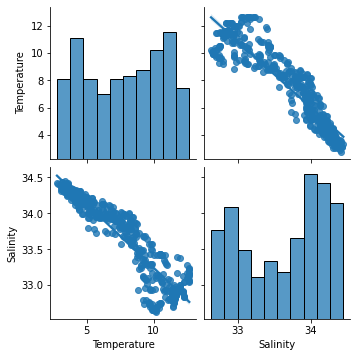

In [31]:
sns.pairplot(bottle_df, kind="reg")

In [32]:
# Посмотрим, сколько значений у нас null
bottle_df.isnull().sum()

Temperature    1
Salinity       6
dtype: int64

In [33]:
# Убираем из датасеты NaN
bottle_df.fillna(method='ffill', inplace=True)

In [34]:
X = np.array(bottle_df['Salinity']).reshape(-1, 1)
y = np.array(bottle_df['Temperature']).reshape(-1, 1)

In [35]:
X.shape

(500, 1)

In [36]:
y.shape

(500, 1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Реализация линейной регрессии

In [38]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        
        n, k = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self
        
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred
    
    def get_weights(self):
        return self.w

Посмотрим на то, как распределены наши данные.

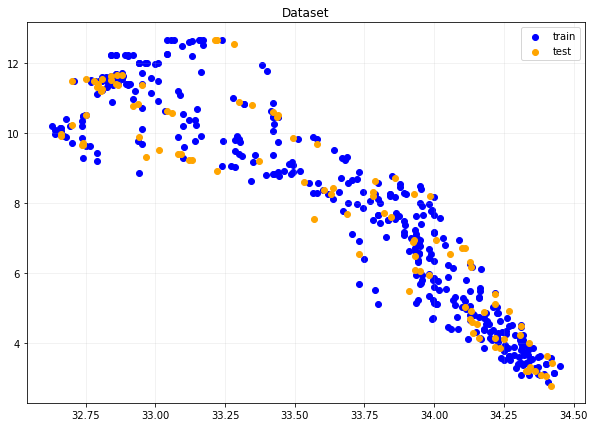

In [39]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

Обучение нашей модели

In [40]:
regressor = MyLinearRegression()

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
w = regressor.get_weights()
w

array([[ -4.84772527],
       [170.87098939]])

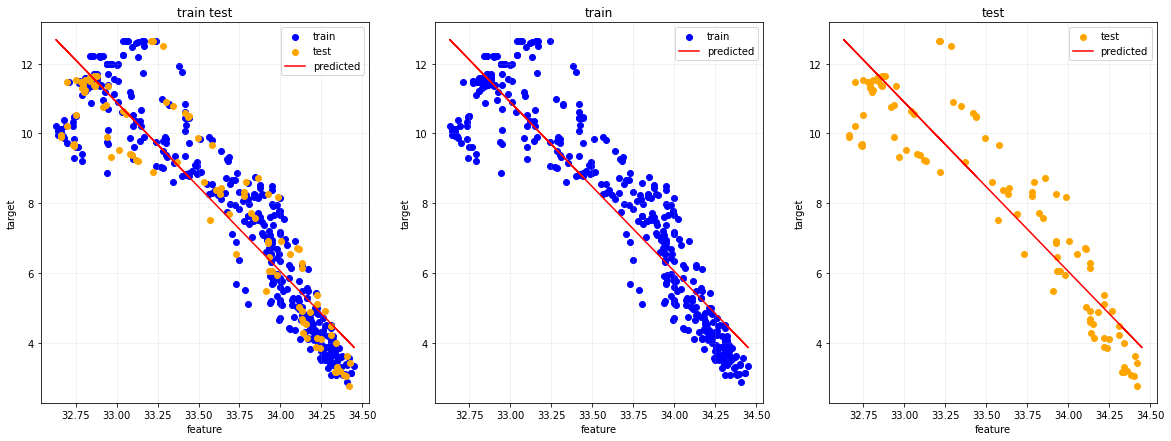

In [41]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, regressor.predict(X), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

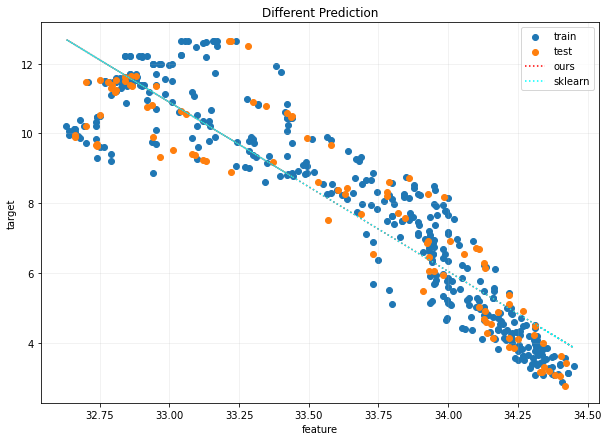

In [42]:
from sklearn.linear_model import LinearRegression
sk_reg = LinearRegression().fit(X_train, y_train)

plt.figure(figsize=(10, 7))

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X), label='ours', c='r', linestyle=':')
plt.plot(X, sk_reg.predict(X), label='sklearn', c='cyan', linestyle=':')

plt.title("Different Prediction")
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error

my_reg_train_predictions = regressor.predict(X_train)
my_reg_test_predictions = regressor.predict(X_test)

sk_reg_train_predictions = sk_reg.predict(X_train)
sk_reg_test_predictions = sk_reg.predict(X_test)

print('My Linear Regression Train MSE: ', mean_squared_error(y_train, my_reg_train_predictions))
print('My Linear Regression Test MSE: ', mean_squared_error(y_test, my_reg_test_predictions))
print('Sklearn Linear Regression Train MSE: ', mean_squared_error(y_train, sk_reg_train_predictions))
print('Sklearn Linear Regression Test MSE: ', mean_squared_error(y_test, sk_reg_test_predictions))

My Linear Regression Train MSE:  1.2432345159933704
My Linear Regression Test MSE:  1.4297614527117073
Sklearn Linear Regression Train MSE:  1.243234515993368
Sklearn Linear Regression Test MSE:  1.4297614527126088


## Выводы
В ходе данной лабораторной работы был реализован алгоритм логистической регрессии. С помощью него мы обучили модель и сравнили её с моделью из библиотеки sklearn. В ходе сравнения получили, что реализованная мною модель немного точнее решала задачу классификации. Во 2 части лабораторной работы был реализован алгоритм линейной регрессии, с помощью которого мы обучили модель и также сравнили её с моделью из sklearn. Графики предсказаний и MSE на обучающей и тестовой выборке показали, что реализованная мною модель предсказывала практически так же, как модель из sklearn.